# Деревья решений

## Построение дерева

Опишем жадный алгоритм построения бинарного дерева решений:
1. Начинаем со всей обучающей выборки $X$, которую помещаем в корень $R_1$. 
2. Задаём функционал качества $Q(X, j, t)$ и критерий остановки. 
3. Запускаем построение из корня: $SplitNode(1, R_1)$

Функция $SplitNode(m, R_m)$
1. Если выполнен критерий остановки, то выход.
2. Находим наилучший с точки зрения $Q$ предикат: $j, t$: $[x_j<t]$
3. Помещаем предикат в вкршину и получаем с его помощью разбиение $X$ на две части: $R_{left} = \lbrace x|x_j<t \rbrace$ и $R_{right} = \lbrace x|x_j \geqslant t \rbrace$
4. Поместим $R_{left}$ и $R_{right}$ соответсвенно в левое и правое поддерево.
5. Рекурсивно повторяем $SplitNode(left, R_{left})$ и $SplitNode(right, R_{right})$.

В конце поставим в соответствие каждому листу ответ. Для задачи классификации - это самый частый среди объектов класс или вектор с долями классов (можно интерпретировать как вероятности):
$$ c_v = \arg \max_{k\in Y} \sum_{(x_i,y_i) \in R_v} [y_i=k]  $$

## Функционал качества для деревьев решений


Энтропия Шеннона для системы с N возможными состояниями определяется по формуле:
$$H = - \sum_{i=0}^{N} p_i\log_2p_i $$

где $p_i$ – вероятности нахождения системы в $i$-ом состоянии. 

Это очень важное понятие теории информации, которое позволяет оценить количество информации (степень хаоса в системе). Чем выше энтропия, тем менее упорядочена система и наоборот. С помощью энтропии мы формализуем функционал качества для разделение выборки (для задачи классификации).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier

Код для расчёта энтропии:

In [2]:
def get_sequence_entropy(seq: np.array) -> float:
    _, counts = np.unique(seq, return_counts=True)
    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
    return entropy

Здесь $y$ - это массив значений целевой переменной

Энтропия – по сути степень хаоса (или неопределенности) в системе. Уменьшение энтропии называют приростом информации (information gain, IG).

Обочначим $R_v$ - объекты, которые нужно разделить в помощью предиката в вершине $v$. Запишем формулу для расчёта информационного прироста:
$$ Q = IG = H(R_v) - (H(R_{left})+H(R_{right}))$$

На каждом шаге нам нужно максимизировать этот функционал качества. Как это делать? Например, так можно перебрать $t$ для выбранного $j$.

Предыдущая версия формулы прироста информации слишком упрощена. В работе необходимо использовать более устойчивую формулу, которая учитывает не только энтропию подмножеств, но и их размер. 

$$ Q = IG = H(R_v) - \Big (\frac{|R_{left}|} {|R_{v}|} H(R_{left})+ \frac{|R_{right}|} {|R_{v}|} H(R_{right})\Big)$$

где, $|R_{v}|$, $|R_{left}|$ и $|R_{right}|$ - количество элементов в соответствующих множествах.


### Задание 4.1

Реализуйте алгоритм построения дерева. Должны быть отдельные функции (методы) для расчёта энтропии (уже есть), для разделения дерева (используйте `pandas`), для подсчёта функционала качества $IG$, для выбора наилучшего разделения (с учетом признакоd и порогов), для проверки критерия остановки.

Для набора данных `iris` реализуйте алгоритм и минимум три из разными критерия остановки из перечисленных ниже:
* максимальной глубины дерева = 5
* минимального числа объектов в листе = 5
* максимальное количество листьев в дереве = 5
* purity (остановка, если все объекты в листе относятся к одному классу)

Реализуйте функцию `predict` (на вход функции подаётся датафрейм с объектами)

Оцените точность каждой модели с помощью метрики доля правильных ответов (`from sklearn.metrics import accuracy_score` или реализовать свою).

In [3]:
class Node:
    def __init__(self,
                 x: pd.DataFrame,
                 y: pd.DataFrame,
                 features_to_use: int,
                 split_feature: str = None,
                 split_value: float = None):

        self.x = x
        self.y = y
        self.features_to_use = features_to_use
        self.split_feature = split_feature
        self.split_value = split_value
        self.left_child = None
        self.right_child = None

    def __str__(self):
        return f"{self.size()}, {self.find_most_common_class()}, {self.split_feature} <= {self.split_value}\n" \
               f"Left - {self.left_child}\nRight - {self.right_child}"

    def __get_entropy(self) -> float:
        return get_sequence_entropy(self.y.to_numpy())

    def __calculate_information_gain(self, split_feature: str, split_value: int) -> float:
        left_p = self.x.query(f"{split_feature} <= {split_value}").index
        right_p = self.x.query(f"{split_feature} > {split_value}").index

        parent_entropy = self.__get_entropy()
        left_child_entropy = get_sequence_entropy(self.y.loc[left_p].to_numpy())
        right_child_entropy = get_sequence_entropy(self.y.loc[right_p].to_numpy())

        left_child_weight = left_p.size / self.size() * left_child_entropy
        right_child_weight = right_p.size / self.size() * right_child_entropy
        return parent_entropy - (left_child_weight + right_child_weight)

    def split_impossible(self) -> bool:
        return not self.is_leaf() or self.find_most_common_class()[1] == self.size()

    def size(self) -> int:
        return self.x.shape[0]

    def depth(self) -> int:
        if self.is_leaf():
            return 1

        return 1 + max(self.left_child.depth(), self.right_child.depth())

    def is_leaf(self) -> bool:
        return self.left_child is None and self.right_child is None

    def find_most_common_class(self) -> (int, int):
        return Counter(self.y.to_numpy()).most_common()[0]

    def find_best_split(self) -> (str, int, float):
        best_feature, best_value, best_gain = None, 0, 0
        for feature in np.random.choice(self.x.columns, self.features_to_use, replace=False):
            # cannot split by first or last item
            items = self.x[feature].iloc[1:-1].to_numpy()
            for value in items:
                gain = self.__calculate_information_gain(feature, value)
                if gain > best_gain:
                    best_feature = feature
                    best_gain = gain
                    best_value = value

        return best_feature, best_value, best_gain

    def split_node(self, split_feature, split_value):
        self.split_feature = split_feature
        self.split_value = split_value

        left_p = self.x.query(f"{split_feature} <= {split_value}").index
        self.left_child = Node(self.x.loc[left_p], self.y.loc[left_p], features_to_use=self.features_to_use)
        right_p = self.x.query(f"{split_feature} > {split_value}").index
        self.right_child = Node(self.x.loc[right_p], self.y.loc[right_p], features_to_use=self.features_to_use)

        return self.left_child, self.right_child

In [4]:
class DecisionTree:
    def __init__(self,
                 features_to_use: int,
                 max_depth: int = 5,
                 min_samples_split: int = 5,
                 max_leaf_nodes: int = 5):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_leaf_nodes = max_leaf_nodes
        self.features_to_use = features_to_use
        self.root = None
        self.nodes = []

    def __str__(self):
        return f"Tree:\n{self.root}"

    def get_leaves_count(self) -> int:
        return np.count_nonzero([node.is_leaf() for node in self.nodes])

    def get_depth(self) -> int:
        return self.root.depth()

    def check_leaves_count(self) -> bool:
        if self.max_leaf_nodes is None:
            return True

        return self.get_leaves_count() < self.max_leaf_nodes

    def check_samples_count(self) -> bool:
        if self.min_samples_split is None:
            return True

        return np.any([node.size() >= self.min_samples_split for node in self.nodes])

    def check_depth(self):
        if self.max_depth is None:
            return True

        return self.get_depth() < self.max_depth

    def continue_splitting(self) -> bool:
        return self.check_leaves_count() and self.check_samples_count() and self.check_depth()

    def fit(self, train_data: pd.DataFrame) -> None:
        copied_data = train_data.copy(deep=True).reset_index(drop=True)
        self.root = Node(copied_data.iloc[:, :-1], copied_data.iloc[:, -1], features_to_use=self.features_to_use)
        self.nodes.append(self.root)

    def process_training_data(self) -> None:
        next_generation = self.nodes.copy()
        while self.continue_splitting():
            process_nodes = next_generation.copy()
            next_generation = []
            while len(process_nodes) > 0:
                node = process_nodes.pop(0)
                if node.split_impossible():
                    continue

                split_feature, split_value, gain = node.find_best_split()
                if gain == 0:
                    continue

                left_child, right_child = node.split_node(split_feature, split_value)

                self.nodes.append(left_child)
                self.nodes.append(right_child)

                next_generation.append(left_child)
                next_generation.append(right_child)

            if len(next_generation) == 0:
                break

    def predict(self, test_data: pd.DataFrame) -> np.array:
        predictions = []
        for _, row in test_data.iterrows():
            node = self.root
            while not node.is_leaf():
                if row[node.split_feature] <= node.split_value:
                    node = node.left_child
                    continue

                node = node.right_child

            predictions.append(node.find_most_common_class()[0])

        return np.array(predictions)

#### Тест дерева решений


In [20]:
iris = datasets.load_iris()
column_names = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
data = pd.DataFrame(iris.data, columns=column_names)
data["target"] = iris.target
train_data, test_data = train_test_split(data, test_size=0.2)
test_x = test_data.copy(deep=True).drop("target", axis=1)

Для максимальной глубины 10 и неограниченых минимального разделения вершины, максимального количества листов.

In [21]:
model_depth = DecisionTree(features_to_use=4, max_depth=10, min_samples_split=None, max_leaf_nodes=None)
model_depth.fit(train_data)
model_depth.process_training_data()

y_pred_depth = model_depth.predict(test_x)
test_data["target_pred_depth"] = y_pred_depth
print(f"My model prediction:\n{y_pred_depth.astype(int)}")
print(f"Test data:\n{test_data.target.to_numpy().astype(int)}")
print(f"Accuracy by sklearn = {accuracy_score(test_data.target, y_pred_depth):.3f}")

My model prediction:
[2 2 2 2 0 0 1 2 2 2 2 1 0 2 0 1 2 1 1 0 2 1 0 0 2 1 2 0 2 0]
Test data:
[2 2 2 2 0 0 1 2 2 2 2 1 0 2 0 0 2 1 1 0 2 1 0 0 1 1 2 0 2 0]
Accuracy by sklearn = 0.933


Для минимального разделения вершины 3 и неограниченных максимальной глубины, количества листов.



In [22]:
model_split = DecisionTree(features_to_use=4, max_depth=None, min_samples_split=3, max_leaf_nodes=None)
model_split.fit(train_data)
model_split.process_training_data()

y_pred_split = model_split.predict(test_x)
test_data["target_pred_split"] = y_pred_split
print(f"My model prediction:\n{y_pred_split.astype(int)}")
print(f"Test data:\n{test_data.target.to_numpy().astype(int)}")
print(f"Accuracy by sklearn = {accuracy_score(test_data.target, y_pred_split):.3f}")

My model prediction:
[2 2 2 2 0 0 1 2 2 2 2 1 0 2 0 0 2 1 1 0 2 1 0 0 2 1 2 0 2 0]
Test data:
[2 2 2 2 0 0 1 2 2 2 2 1 0 2 0 0 2 1 1 0 2 1 0 0 1 1 2 0 2 0]
Accuracy by sklearn = 0.967


Для максимального количества листов 10 и неограниченных максимальной глубины, минимального разделения верхины.

In [23]:
model_leaf = DecisionTree(features_to_use=4, max_depth=None, min_samples_split=None, max_leaf_nodes=10)
model_leaf.fit(train_data)
model_leaf.process_training_data()

y_pred_leaf = model_leaf.predict(test_x)
test_data["target_pred_leaf"] = y_pred_leaf
print(f"My model prediction:\n{y_pred_split.astype(int)}")
print(f"Test data:\n{test_data.target.to_numpy().astype(int)}")
print(f"Accuracy by sklearn = {accuracy_score(test_data.target, y_pred_leaf):.3f}")

My model prediction:
[2 2 2 2 0 0 1 2 2 2 2 1 0 2 0 0 2 1 1 0 2 1 0 0 2 1 2 0 2 0]
Test data:
[2 2 2 2 0 0 1 2 2 2 2 1 0 2 0 0 2 1 1 0 2 1 0 0 1 1 2 0 2 0]
Accuracy by sklearn = 0.900


In [24]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,target,target_pred_depth,target_pred_split,target_pred_leaf
125,7.2,3.2,6.0,1.8,2,2,2,2
123,6.3,2.7,4.9,1.8,2,2,2,1
102,7.1,3.0,5.9,2.1,2,2,2,2
127,6.1,3.0,4.9,1.8,2,2,2,2
32,5.2,4.1,1.5,0.1,0,0,0,0
31,5.4,3.4,1.5,0.4,0,0,0,0
76,6.8,2.8,4.8,1.4,1,1,1,1
111,6.4,2.7,5.3,1.9,2,2,2,2
107,7.3,2.9,6.3,1.8,2,2,2,2
103,6.3,2.9,5.6,1.8,2,2,2,2


##  Случайный лес

Опишем алгоритм случайный лес (*random forest*) и попутно разберём основные идеи:

1. Зададим $N$ - число деревьев в лесу.
2. Для каждого $n$ из $N$ сгенерируем свою выборку $X_n$. Пусть $m$ - это количество объектов в $X$. При генерации каждой $X_n$ мы будем брать объекты $m$ раз с возвращением. То есть один и тот же объект может попасть в выборку несколько раз, а какие-то объекты не попадут. (Этот способ назвается бутстрап).
3. По каждой $X_n$ построим решающее дерево $b_n$. Обычно стараются делать глубокие деревья. В качестве критериев остановки можно использовать `max_depth` или `min_samples_leaf` (например, пока в каждом листе не окажется по одному объекту). При каждом разбиении сначала выбирается $k$ (эвристика $k = \sqrt d$, где $d$ - это число признаков объектов из выборки $X$) случайных признаков из исходных, и оптимальное разделение выборки ищется только среди них. Обратите внимание, что мы не выбрасываем оставшиеся признаки!
4. Итоговый алгоритм будет представлять собой результат голосования (для классификации) и среднее арифметическое (для регрессии). Модификация алгоритма предполагает учёт весов каждого отдельного слабого алгоритма в ансамбле, но в этом особо нет смысла.


### Задание 4.2

В качестве набора данных используйте: https://www.kaggle.com/mathchi/churn-for-bank-customers

Там есть описание и примеры работы с этими данными. Если кратко, речь идёт про задачу прогнозирования оттока клиентов. Есть данные о 10 тысячах клиентов банка, часть из которых больше не являются клиентами.

Используя либо свою реализацию, либо  `DecisionTreeClassifier` с разными настройками из `sklearn.tree` реализйте алгоритм "случайный лес". 

Найдите наилучшие гиперпараметры этого алгоритма: количество деревьев, критерий остановки, функционал качества, минимальное количество объектов в листьях и другие.

Нельзя использовать готовую реализацию случайного леса из `sklearn`.

В подобных задачах очень важна интерпретируемость алгоритма. Попытайтесь оценить информативность признаков, т.е. ответить а вопрос, значения каких признаков являются самыми важными индикаторами того, что банк потеряет клиента.

In [ ]:
from google.colab import drive


drive.mount("/google_drive")

Mounted at /google_drive


In [ ]:
data = pd.read_csv("/google_drive/MyDrive/churn.csv", sep=",")
data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
class Boostrap:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.samples = None
        self.out_of_bag_samples = None

    def calculate_features_to_use(self) -> int:
        return np.sqrt(self.data.shape[1] - 1).astype(int)

    def create_samples(self, sample_size: int, sample_count: int) -> list:
        self.samples = [self.data.sample(n=sample_size, replace=True) for _ in range(sample_count)]
        return self.samples

    def create_out_of_bag_sample(self) -> pd.DataFrame:
        used_indexes = np.array([])
        for sample in self.samples:
            if not used_indexes.size:
                used_indexes = sample.index
                continue

            used_indexes = np.append(used_indexes, np.setdiff1d(sample.index, used_indexes))

        self.out_of_bag_samples = self.data.copy(deep=True).drop(used_indexes)
        return self.out_of_bag_samples

In [ ]:
class RandomForest:
    def __init__(self,
                 features_to_use: int,
                 n_trees: int = 5,
                 max_depth: int = 5,
                 min_samples_split: int = 5):

        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.features_to_use = features_to_use

    def __build_tree(self) -> DecisionTree:
        tree = DecisionTree(self.features_to_use,
                            max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            max_leaf_nodes=10**6)
        return tree

    def fit(self, train_samples: list) -> None:
        if len(train_samples) != self.n_trees:
            raise ValueError("Number of samples should be equal to number of trees")
        
        for _ in range(self.n_trees):
            tree = self.__build_tree()
            self.trees.append(tree)

        for tree, sample in zip(self.trees, train_samples):
            tree.fit(sample)

    def process_training_data(self) -> None:
        for tree in self.trees:
            tree.process_training_data()

    def predict(self, test_data: pd.DataFrame) -> np.array:
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(test_data))

        predictions = np.array(predictions)
        y_pred = np.apply_along_axis(lambda x: Counter(x).most_common()[0][0], axis=0, arr=predictions)

        return y_pred

#### Тест случайного леса для моей релизации дерева
Для 5 деревьев, выборка для каждого 500 строк, количество используемых параметров = [sqrt(12)] = 3. Параметры дерева как в задании 4.1

In [ ]:
# remove unnecessary columns, which are not informative for the model
process_data = data.copy(deep=True).drop(columns=["RowNumber", "CustomerId", "Surname"])
process_data.replace({"Male": 0, "Female": 1}, inplace=True)
process_data[
    ["isFrance", "isGermany", "isSpain"]] = pd.get_dummies(process_data.Geography.str.split().str[0], dtype=int)
process_data.drop(columns=["Geography"], inplace=True)
process_data = process_data.reindex(columns=["CreditScore", "isFrance", "isGermany", "isSpain",	"Gender", "Age",
                                                "Tenure", "Balance", "NumOfProducts", "HasCrCard",	"IsActiveMember",
                                                "EstimatedSalary",	"Exited"])

In [ ]:
process_data

,CreditScore,isFrance,isGermany,isSpain,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,1,0,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,0,0,1,1,41,1,83807.86,1,0,1,112542.58,0
2,502,1,0,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,1,0,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,0,0,1,1,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,1,0,0,0,39,5,0.00,2,1,0,96270.64,0
9996,516,1,0,0,0,35,10,57369.61,1,1,1,101699.77,0
9997,709,1,0,0,1,36,7,0.00,1,0,1,42085.58,1
9998,772,0,1,0,0,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
boostrap = Boostrap(process_data)
samples = boostrap.create_samples(sample_size=500, sample_count=5)
out_of_bag_sample = boostrap.create_out_of_bag_sample()
features_to_use = boostrap.calculate_features_to_use()

model = RandomForest(features_to_use, n_trees=5, max_depth=10, min_samples_split=5)
model.fit(samples)
model.process_training_data()

y_pred = model.predict(out_of_bag_sample)
out_of_bag_sample["target"] = y_pred

In [ ]:
print(f"Accuracy by sklearn = {accuracy_score(out_of_bag_sample.Exited, y_pred):.3f}")
out_of_bag_sample

Accuracy by sklearn = 0.830


,CreditScore,isFrance,isGermany,isSpain,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,target
0,619,1,0,0,1,42,2,0.00,1,1,1,101348.88,1,0
1,608,0,0,1,1,41,1,83807.86,1,0,1,112542.58,0,0
2,502,1,0,0,1,42,8,159660.80,3,1,0,113931.57,1,0
3,699,1,0,0,1,39,1,0.00,2,0,0,93826.63,0,0
4,850,0,0,1,1,43,2,125510.82,1,1,1,79084.10,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,800,1,0,0,1,29,2,0.00,2,0,0,167773.55,0,0
9995,771,1,0,0,0,39,5,0.00,2,1,0,96270.64,0,0
9996,516,1,0,0,0,35,10,57369.61,1,1,1,101699.77,0,0
9997,709,1,0,0,1,36,7,0.00,1,0,1,42085.58,1,0


In [ ]:
y_pred_full = model.predict(process_data)

errors = []
for column in process_data.columns[:-1]:
    shuffled_data = process_data.copy(deep=True)
    shuffled_data[column] = np.random.permutation(shuffled_data[column].values)

    boostrap_feature = Boostrap(shuffled_data)
    samples_feature = boostrap_feature.create_samples(sample_size=500, sample_count=5)
    features_to_use_feature = boostrap_feature.calculate_features_to_use()

    model_feature = RandomForest(features_to_use_feature, n_trees=5, max_depth=10, min_samples_split=5)
    model_feature.fit(samples_feature)
    model_feature.process_training_data()
    y_pred_feature = model_feature.predict(shuffled_data)
    error = np.sqrt(mean_squared_error(y_pred_feature, y_pred_full))
    errors.append(error)
    print(f"RMSE for column {column} = {error:.3f}")

RMSE for column CreditScore = 0.313
RMSE for column isFrance = 0.335
RMSE for column isGermany = 0.323
RMSE for column isSpain = 0.317
RMSE for column Gender = 0.309
RMSE for column Age = 0.355
RMSE for column Tenure = 0.318
RMSE for column Balance = 0.305
RMSE for column NumOfProducts = 0.341
RMSE for column HasCrCard = 0.313
RMSE for column IsActiveMember = 0.344
RMSE for column EstimatedSalary = 0.333


<BarContainer object of 10 artists>

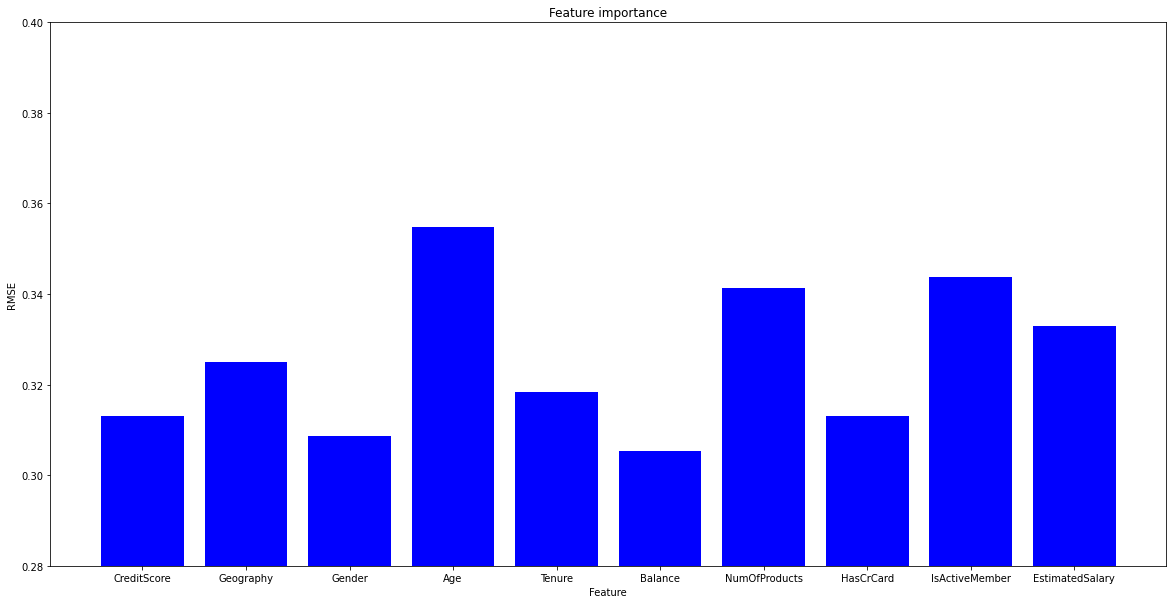

In [ ]:
errors_stack = np.array([errors[0], np.mean(errors[1:4]), *errors[4:]])
columns = process_data.columns[:-1]
columns = np.array([columns[0], "Geography", *columns[4:]])

x_default_labels = np.arange(len(errors_stack))
plt.figure(figsize=(20, 10))
plt.title("Feature importance")
plt.xlabel("Feature")
plt.ylabel("RMSE")
plt.xticks(x_default_labels, columns)
plt.ylim(0.28, 0.4)
plt.bar(x_default_labels, errors_stack, color="blue")

#### Тест случайного леса для реализации дерева решений из sklearn
В качестве алгоритма выбора признака использован критерий Джини (намного меньше накладных расходов при сравнимой точности).

Чтобы добиться наивысшей точности использовано 40 деревьев, для каждого выборка из 1000 строк. Параметры дерева: максимальная глубина 40, минимальное разделение - 2.

In [ ]:
class RandomForestSK:
    def __init__(self,
                 features_to_use: int,
                 n_trees: int = 5,
                 max_depth: int = 5,
                 min_samples_split: int = 5):

        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []
        self.features_to_use = features_to_use

    def __build_tree(self) -> DecisionTreeClassifier:
        tree = DecisionTreeClassifier(
            criterion="gini",
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            max_leaf_nodes=10**6,
            max_features=self.features_to_use)

        return tree

    def fit(self, train_samples: list) -> None:
        if len(train_samples) != self.n_trees:
            raise ValueError("Number of samples should be equal to number of trees")

        for _ in range(self.n_trees):
            tree = self.__build_tree()
            self.trees.append(tree)

        for tree, sample in zip(self.trees, train_samples):
            tree.fit(sample.drop("Exited", axis=1).values, sample["Exited"].values)

    def predict(self, test_data: pd.DataFrame) -> np.array:
        predictions = []
        for tree in self.trees:
            predictions.append(tree.predict(test_data.drop("Exited", axis=1).values))

        predictions = np.array(predictions)
        y_pred = np.apply_along_axis(lambda x: Counter(x).most_common()[0][0], axis=0, arr=predictions)

        return y_pred

In [ ]:
boostrap_sk = Boostrap(process_data)
samples_sk = boostrap_sk.create_samples(sample_size=1000, sample_count=40)
out_of_bag_sample_sk = boostrap_sk.create_out_of_bag_sample()
features_to_use_sk = boostrap_sk.calculate_features_to_use()

model_sk = RandomForestSK(features_to_use_sk, n_trees=40, max_depth=30, min_samples_split=2)
model_sk.fit(samples_sk)

y_pred_sk = model_sk.predict(out_of_bag_sample_sk)
out_of_bag_sample_sk["target"] = y_pred_sk
print(f"Accuracy by sklearn = {accuracy_score(out_of_bag_sample_sk.Exited, y_pred_sk):.3f}")
out_of_bag_sample_sk

Accuracy by sklearn = 0.837


,CreditScore,isFrance,isGermany,isSpain,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,target
7,376,0,1,0,1,29,4,115046.74,4,1,0,119346.88,1,1
48,550,0,1,0,0,38,2,103391.38,1,0,1,90878.13,0,0
135,589,0,1,0,1,50,5,144895.05,2,1,1,34941.23,0,0
138,584,0,0,1,1,48,2,213146.20,1,1,0,75161.25,1,1
207,618,1,0,0,0,34,5,134954.53,1,1,1,151954.39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9694,581,1,0,0,0,25,5,77886.53,2,1,0,150319.49,0,0
9803,673,1,0,0,0,31,1,108345.22,1,0,1,38802.03,0,0
9902,730,1,0,0,1,27,7,0.00,2,1,0,144099.48,0,0
9971,833,1,0,0,1,34,3,144751.81,1,0,0,166472.81,0,0


In [ ]:
y_pred_full_sk = model_sk.predict(process_data)

errors_sk = []
for column in process_data.columns[:-1]:
    shuffled_data_sk = process_data.copy(deep=True)
    shuffled_data_sk[column] = np.random.permutation(shuffled_data_sk[column].values)

    boostrap_feature_sk = Boostrap(shuffled_data_sk)
    samples_feature_sk = boostrap_feature_sk.create_samples(sample_size=1000, sample_count=40)
    features_to_use_feature_sk = boostrap_feature_sk.calculate_features_to_use()

    model_feature_sk = RandomForestSK(features_to_use_feature_sk, n_trees=40, max_depth=30, min_samples_split=2)
    model_feature_sk.fit(samples_feature_sk)
    y_pred_feature = model_feature_sk.predict(shuffled_data_sk)
    error_sk = np.sqrt(mean_squared_error(y_pred_feature, y_pred_full_sk))
    errors_sk.append(error_sk)
    print(f"RMSE for column {column} = {error_sk:.3f}")

RMSE for column CreditScore = 0.185
RMSE for column isFrance = 0.177
RMSE for column isGermany = 0.182
RMSE for column isSpain = 0.184
RMSE for column Gender = 0.182
RMSE for column Age = 0.297
RMSE for column Tenure = 0.179
RMSE for column Balance = 0.190
RMSE for column NumOfProducts = 0.249
RMSE for column HasCrCard = 0.187
RMSE for column IsActiveMember = 0.232
RMSE for column EstimatedSalary = 0.185


<BarContainer object of 10 artists>

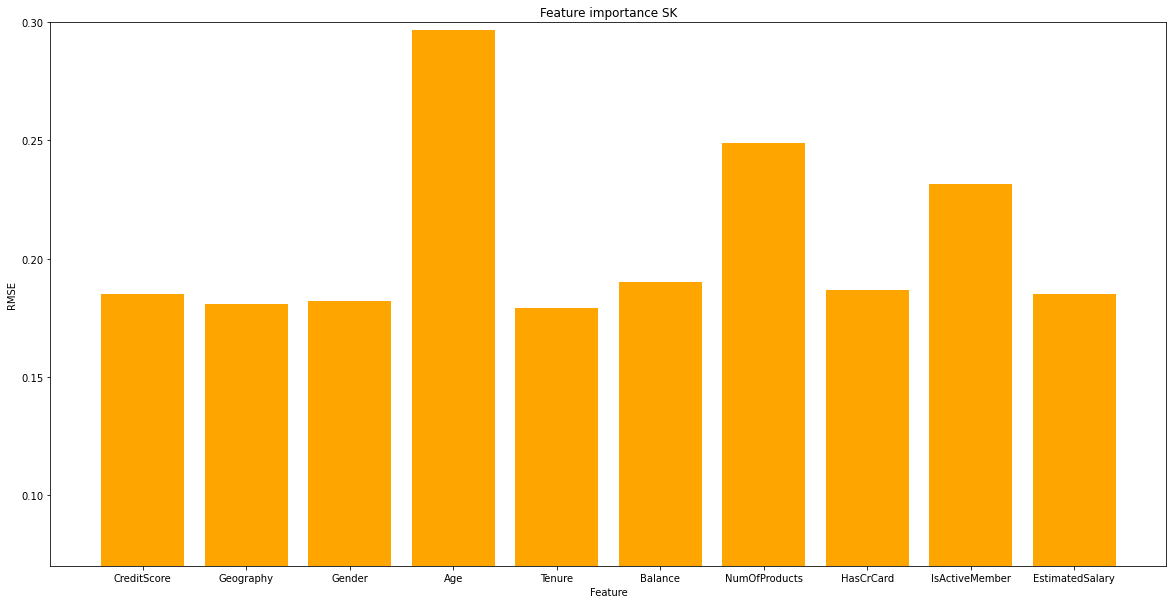

In [ ]:
errors_sk_stack = np.array([errors_sk[0], np.mean(errors_sk[1:4]), *errors_sk[4:]])
columns_stack = process_data.columns[:-1]
columns_stack = np.array([columns_stack[0], "Geography", *columns_stack[4:]])

x_default_labels_sk = np.arange(len(errors_sk_stack))
plt.figure(figsize=(20, 10))
plt.title("Feature importance SK")
plt.xlabel("Feature")
plt.ylabel("RMSE")
plt.xticks(x_default_labels_sk, columns_stack)
plt.ylim(0.07, 0.3)
plt.bar(x_default_labels_sk, errors_sk_stack, color="orange")

#### Поиск наилучших параметров для модели

In [ ]:
accuracy, best_n_trees, best_max_depth, best_min_samples_split, best_sample_size = [-1 for _ in range(5)]
sample_size_arr = np.arange(7000, 9500, 500)  # 5
trees_count_arr = np.arange(48, 63, 3)  # 5
max_depth_arr = np.arange(27, 42, 3)  # 5
min_samples_split_arr = np.arange(3, 1, -1)  # 2 

for trees_count in trees_count_arr:
    for max_depth in max_depth_arr:
        for min_samples_split in min_samples_split_arr:
            for sample_size in sample_size_arr:
                bootstrap_p = Boostrap(process_data)
                bootstrap_p.create_samples(sample_size=sample_size, sample_count=trees_count)
                random_forest = RandomForestSK(features_to_use=bootstrap_p.calculate_features_to_use(),
                                                n_trees=trees_count,
                                                max_depth=max_depth,
                                                min_samples_split=min_samples_split)

                random_forest.fit(bootstrap_p.samples)
                y_pred_p = random_forest.predict(process_data)

                cur_accuracy = accuracy_score(process_data.Exited, y_pred_p)
                if cur_accuracy > accuracy:
                    accuracy = cur_accuracy
                    best_n_trees = trees_count
                    best_max_depth = max_depth
                    best_min_samples_split = min_samples_split
                    best_sample_size = sample_size

print(f"Best accuracy: {accuracy}")
print(f"Best number of trees: {best_n_trees}")
print(f"Best max depth: {best_max_depth}")
print(f"Best min samples split: {best_min_samples_split}")
print(f"Best sample size: {best_sample_size}")

Best accuracy: 0.9995
Best number of trees: 60
Best max depth: 27
Best min samples split: 2
Best sample size: 9000


##  Выводы по эксперименту

1.   Дерево решений из sklearn строится существенно быстрее, это связано с выбором алгоритма выбора признака. Точность же, при одинаковых параметрах случайного леса и деревьев, у моей модели выше, что также характерно для gain и gini критериев.
2.   Интерпретации результатов у обеих моделей схожи, наиважнейшими критериями являются Age, NumOfProducts и IsActiveMember. На втором графике это выражено более явно, т.к. модель получилась точнее из-за большего числа деревьев, их глубины.
3. Точность алгоритма растёт при увеличении объёма выборки, количества деревьев, максимальной глубины и уменьшении количества элементов в листе. Добиться идеальной точности (≈1.0) можно, к примеру, с помощью параметров, обозначенных выше.



